# 2-D Ising model part one (exercise)

![Example output](images/ising_animation.gif)

The main purpose of this notebook is to go through a problem-solving arc when porting existing serial code to be executed on a GPU.

This example borrows heavily from the [Numba example](https://github.com/NVIDIA/ising-gpu/blob/master/basic_python/ising_basic.py) from:

Romero, J., Bisson, M., Fatica, M., & Bernaschi, M. (2019). A Performance Study of the 2D Ising Model on GPUs. *CoRR*, *abs/1906.06297*. Retrieved from [http://arxiv.org/abs/1906.06297](http://arxiv.org/abs/1906.06297)

## Background

The [Ising model](https://en.wikipedia.org/wiki/Ising_model) can be used as a prototypical model of ferromagnetism in statistical mechanics, exhibiting rich emergent behavior.

Consider a two-dimensional grid of lattice sites. At each lattice site is a spin $\sigma_k$ that can be in one of two states ($+1$ or $-1$). Each spin only interacts with its nearest neighbors (four in 2-D).

In the absence of an external magnetic field, the Hamiltonian for this system can be defined in the following form:

\begin{equation}
H(\sigma) = - \displaystyle\sum_{\langle i j\rangle} J_{ij} \sigma_i \sigma_j,
\end{equation}

where $J_{ij}$ is an interaction parameter, which we set to be $1$ for all pairs for simplicity.

Note that when $\sigma_i \sigma_j$ are both aligned (e.g. both have the same sign),
the overall contribution to the total energy of the configuration is negative.
Since lower-energy states are preferred, we see that there is a tendency of neighboring spins to align.

Counteracting this tendency for spins to align is temperature, which causes random fluctuations in a lattice site's spin state, irrespective of their neighbor's states.
The tendency for a spin to randomly switch states increases with temperature.

Numerical simulations can be used to model the dynamics of such a system.
While the simplified model we aim to simulate in this notebook has well-known analytical results, computer simulations become indispensable as more complexity is added, such as higher dimensions, an external magnetic field, irregular lattice geometries, etc.

The **Metropolis–Hastings algorithm** can be used to simulate the Ising model on a computer.
Starting from an initial state that we select (e.g. completely random, completely ordered, something else), we perform the following operations:

1. Randomly select one spin on the lattice
2. Consider flipping the spin:
  - Calculate the total change in system energy if the flip was accepted ($\Delta E$)
3. Decide if the flip should be accepted
  - If flipping the spin lowers the total energy, accept the flip.
  - If flipping the spin increases the total energy, accept the flip with a probability $e^{-\Delta E / k_B T }$, which depends on the energy increase $\Delta E$ and temperature ($T$). $k_B$ is Boltzmann's constant.
4. Update the spin (or not) according to the previous step.

Steps 1 through 4 are repeated for many steps until the system moves into a state of thermal equilibrium.

## A basic Python implementation

The following is a basic Python implementation of the above algorithm to give a starting point.

We are restricted to relatively small lattice sizes since the simulation is not very performant.

In [1]:
import random
import math


def initialize_lattice(L):
    """
    Initializes an L x L lattice with random spins (+1 or -1).
    Returns the lattice as a list of lists.
    """
    lattice = [[random.choice([-1, 1]) for _ in range(L)] for _ in range(L)]
    return lattice


def monte_carlo_step(lattice, L, T):
    """
    Performs one Monte Carlo step (MCS).
    In one MCS, we attempt to flip each spin in the lattice once on average.
    This implementation shuffles the order of sites visited.
    T: Temperature
    Assumes k_B=1 (Boltzmann constant) and J=1 (interaction strength).
    """
    # beta = 1.0 / (k_B * T) where k_B=1
    beta = 1.0 / T

    site_indices = [(r_idx, c_idx) for r_idx in range(L) for c_idx in range(L)]
    random.shuffle(site_indices)

    for i, j in site_indices:
        spin_ij = lattice[i][j]

        # Neighbors: top, bottom, left, right
        nn_sum = (
            lattice[(i - 1 + L) % L][j]
            + lattice[(i + 1) % L][j]
            + lattice[i][(j - 1 + L) % L]
            + lattice[i][(j + 1) % L]
        )

        acceptance_ratio = math.exp(-2.0 * beta * spin_ij * nn_sum)

        if random.random() < acceptance_ratio:
            lattice[i][j] *= -1
        else:
            # Flip is not accepted
            pass

First, we will use some boilerplate code to make a 2-D pseudocolor plot of the lattice evolution at the critical temperature for the first 200 Monte Carlo steps.

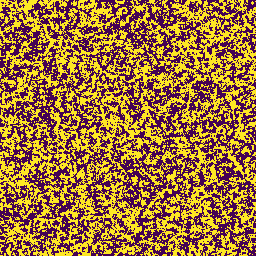

In [2]:
%matplotlib widget

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import IPython.display

import random
import math
import os


def initialize_lattice(L):
    """
    Initializes an L x L lattice with random spins (+1 or -1).
    Returns the lattice as a list of lists.
    """
    lattice = [[random.choice([-1, 1]) for _ in range(L)] for _ in range(L)]
    return lattice


def monte_carlo_step(lattice, L, T):
    """
    Performs one Monte Carlo step (MCS).
    In one MCS, we attempt to flip each spin in the lattice once on average.
    This implementation shuffles the order of sites visited.
    T: Temperature
    Assumes k_B=1 (Boltzmann constant) and J=1 (interaction strength).
    """
    # beta = 1.0 / (k_B * T) where k_B=1
    beta = 1.0 / T

    site_indices = [(r_idx, c_idx) for r_idx in range(L) for c_idx in range(L)]
    random.shuffle(site_indices)

    for i, j in site_indices:
        spin_ij = lattice[i][j]

        # Neighbors: top, bottom, left, right
        nn_sum = (
            lattice[(i - 1 + L) % L][j]
            + lattice[(i + 1) % L][j]
            + lattice[i][(j - 1 + L) % L]
            + lattice[i][(j + 1) % L]
        )

        acceptance_ratio = math.exp(-2.0 * beta * spin_ij * nn_sum)

        if random.random() < acceptance_ratio:
            lattice[i][j] *= -1
        else:
            # Flip is not accepted
            pass


# --- Simulation Parameters ---
LATTICE_SIZE = 256
TEMPERATURE = 2.269  # Critical temperature for 2D Ising is ~2.269 (J=1, k_B=1)
# Try other temperatures: T_low = 1.0 (ordered), T_high = 5.0 (disordered)

lattice = initialize_lattice(LATTICE_SIZE)

# Get viridis colormap
viridis = plt.cm.viridis
norm = Normalize(vmin=-1, vmax=1)

# Collect frames as arrays instead of images
frames = []

for i in range(200):
    monte_carlo_step(lattice, LATTICE_SIZE, TEMPERATURE)

    # Copy to CPU and apply colormap
    colored_frame = viridis(norm(np.array(lattice)))

    # Convert to RGB
    rgb_frame = (colored_frame[:, :, :3] * 255).astype(np.uint8)
    frames.append(rgb_frame)

# Convert to PIL images and save
pil_images = [Image.fromarray(frame, mode="RGB") for frame in frames]
output_filename = f"output/{LATTICE_SIZE}x{LATTICE_SIZE}_{TEMPERATURE}.gif"

# Create output directory if it doesn't exist
os.makedirs(os.path.dirname(output_filename), exist_ok=True)

pil_images[0].save(
    output_filename, save_all=True, append_images=pil_images[1:], duration=100, loop=0
)

IPython.display.Image(output_filename)


We can also compute and plot the time history of the average magnetization.

Try different values for the temperature to gain some intuition for how the magnetization of the system reflect an ordered vs. disordered state.

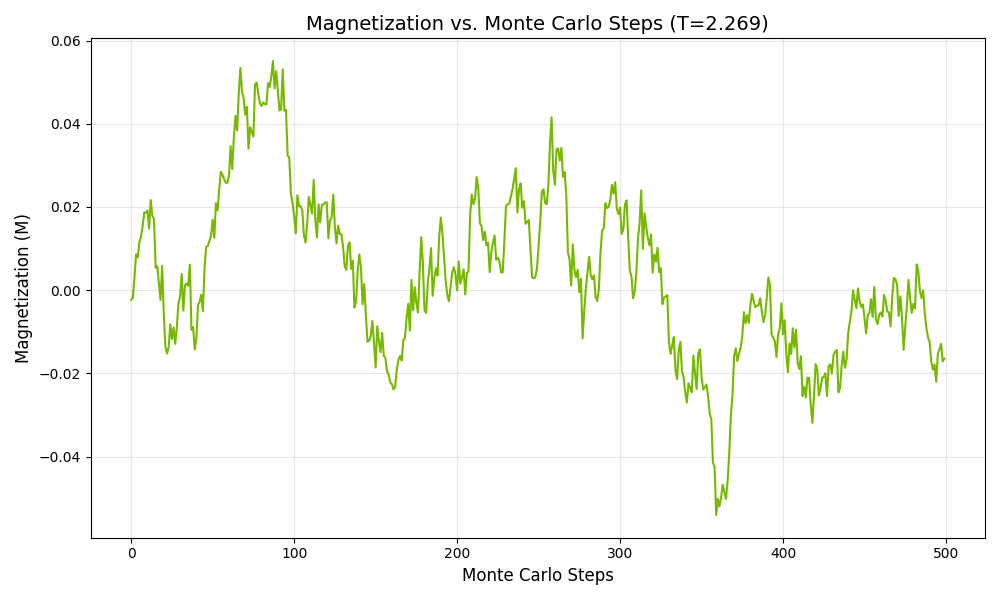

In [3]:
# --- Simulation Parameters ---
LATTICE_SIZE = 256
TEMPERATURE = 2.269  # Critical temperature for 2D Ising is ~2.269 (J=1, k_B=1)
# Try other temperatures: T_low = 1.0 (ordered), T_high = 5.0 (disordered)

lattice = initialize_lattice(LATTICE_SIZE)
magnetization_values = []


def calculate_magnetization(lattice, L):
    """
    Calculates the total magnetization of the lattice.
    Normalized magnetization m = (sum of all spins) / (L*L)
    """
    total_spin = sum(sum(row) for row in lattice)
    return total_spin / (L * L)


for i in range(500):
    monte_carlo_step(lattice, LATTICE_SIZE, TEMPERATURE)
    current_mag = calculate_magnetization(lattice, LATTICE_SIZE)
    magnetization_values.append(current_mag)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(magnetization_values, "-", linewidth=1.5, color="#76b900")

ax.set_xlabel("Monte Carlo Steps", fontsize=12)
ax.set_ylabel("Magnetization (M)", fontsize=12)
ax.set_title(f"Magnetization vs. Monte Carlo Steps (T={TEMPERATURE:.3f})", fontsize=14)
ax.grid(True, alpha=0.3)
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.resizable = False

plt.tight_layout()

## The most naive version

Let's implement a solution that takes advantage of the parallel processing capabilities of a GPU using Warp.

Our inclination might be to write a Warp kernel so that we can perform the following update in parallel by launching it on an $N \times N$ grid:

```python
    for i, j in site_indices:
        spin_ij = lattice[i][j]

        # Neighbors: top, bottom, left, right
        nn_sum = (
            lattice[(i - 1 + L) % L][j]
            + lattice[(i + 1) % L][j]
            + lattice[i][(j - 1 + L) % L]
            + lattice[i][(j + 1) % L]
        )

        acceptance_ratio = math.exp(-2.0 * beta * spin_ij * nn_sum)

        if random.random() < acceptance_ratio:
            lattice[i][j] *= -1
        else:
            # Flip is not accepted
            pass
```

The idea is that we process each lattice site together in parallel instead of one at a time.

So let's proceed down this route and see where it takes us...

### Allocating data

We'd like to allocate storage for the lattice as an $N$ by $N$ array of `wp.int8`.

In [4]:
import warp as wp

LATTICE_SIZE = 256

lattice = wp.empty((LATTICE_SIZE, LATTICE_SIZE), dtype=wp.int8)


Warp 1.8.0 initialized:
   CUDA Toolkit 12.8, Driver 12.8
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA RTX 5000 Ada Generation Laptop GPU" (16 GiB, sm_89, mempool enabled)
   Kernel cache:
     /home/snidhan/.cache/warp/1.8.0


### Generating a random initial condition

We will make use of Warp's built-in random-number generator, which can be called from a kernel.

The basic usage is to create a RNG state (represented as a `wp.uint32`) by storing what is returned by `warp.rand_init(seed: int32, offset: int32)`.

We should pick a common `seed` for all **threads** in the kernel, but have each thread provide a different `offset` to generate uncorrelated values.

We could also use NumPy to give us a random initial condition, but the technique of generating random numbers from within a Warp kernel will help us when we write the `update_lattice` kernel.

In [5]:
@wp.kernel
def generate_lattice(lattice: wp.array2d(dtype=wp.int8), rng_seed: int):
    i, j = wp.tid()

    # Generate random number between [0.0, 1.0).
    # NOTE: To get different values, we can change either (or both) arguments
    rng_state = wp.rand_init(rng_seed, i * lattice.shape[1] + j)
    if wp.randf(rng_state, 0.0, 1.0) < 0.5:
        lattice[i, j] = wp.int8(1)
    else:
        lattice[i, j] = wp.int8(-1)

Let's run this kernel and see how the solution looks. Try running this block a few times. You should see that the result does not change.

**Warp does not persist an internal random number generator state between kernel launches.**

To get different random samples, we should change the seed passed to `generate_lattice`, which is currently set to 42.

Module __main__ 12f4892 load on device 'cuda:0' took 1.03 ms  (cached)


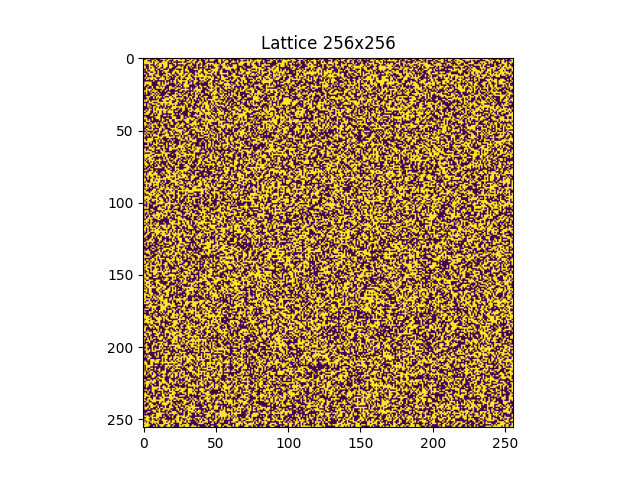

In [6]:
import matplotlib.pyplot as plt

wp.launch(generate_lattice, lattice.shape, inputs=[lattice, 42])

fig = plt.figure()
plt.imshow(lattice.numpy(), cmap="viridis")
plt.title(f"Lattice {LATTICE_SIZE}x{LATTICE_SIZE}")
plt.show()

Next, we'll implement a Warp kernel to update the entire lattice.

Like the `generate_lattice` kernel, we will provide it with the 2-D lattice and a random number seed as inputs.

We will also pass in the inverse temperature $\beta = 1.0/(k_b T)$.

In [7]:
@wp.kernel
def update_lattice(beta: float, rng_seed: int, lattice: wp.array2d(dtype=wp.int8)):
    i, j = wp.tid()

    lattice_size = lattice.shape[0]

    # Neighbors: top, bottom, left, right
    nn_sum = (
        lattice[(i - 1 + lattice_size) % lattice_size, j]
        + lattice[(i + 1) % lattice_size, j]
        + lattice[i, (j - 1 + lattice_size) % lattice_size]
        + lattice[i, (j + 1) % lattice_size]
    )

    # Determine whether to flip spin
    spin_ij = lattice[i, j]
    acceptance_ratio = wp.exp(-2.0 * beta * wp.float32(nn_sum) * wp.float32(spin_ij))

    # Generate a random number between [0.0, 1.0).
    rng_state = wp.rand_init(rng_seed, i * lattice_size + j)

    if wp.randf(rng_state, 0.0, 1.0) < acceptance_ratio:
        lattice[i, j] = -spin_ij
    else:
        # No change
        pass

As with the serial Python implementation, we will call some boilerplate code to make a GIF of the lattice evolution.

Module __main__ 39d5290 load on device 'cuda:0' took 0.61 ms  (cached)


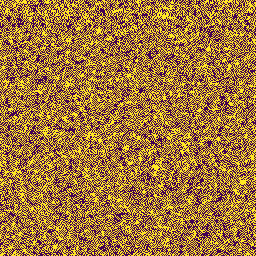

In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import IPython.display

# --- Simulation Parameters ---
LATTICE_SIZE = 256
TEMPERATURE = 2.269  # Critical temperature for 2D Ising is ~2.269 (J=1, k_B=1)
# Try other temperatures: T_low = 1.0 (ordered), T_high = 5.0 (disordered)
BETA = 1.0 / TEMPERATURE

lattice = wp.empty((LATTICE_SIZE, LATTICE_SIZE), dtype=wp.int8)

# Reset initial conditions
wp.launch(generate_lattice, lattice.shape, inputs=[lattice, 42])

# Get viridis colormap
viridis = plt.cm.viridis
norm = Normalize(vmin=-1, vmax=1)

# Collect frames as arrays instead of images
frames = []

for i in range(200):
    wp.launch(update_lattice, lattice.shape, inputs=[BETA, i, lattice])

    # Copy to CPU and apply colormap
    normalized_lattice = norm(lattice.numpy())
    colored_frame = viridis(normalized_lattice)

    # Convert to RGB
    rgb_frame = (colored_frame[:, :, :3] * 255).astype(np.uint8)
    frames.append(rgb_frame)

# Convert to PIL images and save
pil_images = [Image.fromarray(frame, mode="RGB") for frame in frames]
output_filename = f"output/{LATTICE_SIZE}x{LATTICE_SIZE}_{TEMPERATURE}.gif"

pil_images[0].save(
    output_filename, save_all=True, append_images=pil_images[1:], duration=100, loop=0
)

IPython.display.Image(output_filename)

How does this compare to the sequential Python solution?

## Using two arrays for the lattice

<span style="background-color: black; color: black;" onmouseover="this.style.color='white';" onmouseout="this.style.color='black';">
Let's modify the update_lattice kernel to avoid the race condition
so that multiple threads are not trying to read and write shared data in an uncoordinated way.
</span> 


<span style="background-color: black; color: black;" onmouseover="this.style.color='white';" onmouseout="this.style.color='black';">
<p></p>We will use two arrays instead of one. This way, we can write the updated lattice values to a second array, ensuring that the race condition in the previous approach does not exist.
</span> 

The following cell starts with the updated **kernel signature**, but a body that needs to be updated to work with two arrays.

In [9]:
@wp.kernel
def update_lattice(
    beta: float,
    rng_seed: int,
    lattice_in: wp.array2d(dtype=wp.int8),
    lattice_out: wp.array2d(dtype=wp.int8),
):
    i, j = wp.tid()

    # Neighbors: top, bottom, left, right
    nn_sum = (
        lattice_in[(i - 1 + LATTICE_SIZE) % LATTICE_SIZE, j]
        + lattice_in[(i + 1) % LATTICE_SIZE, j]
        + lattice_in[i, (j - 1 + LATTICE_SIZE) % LATTICE_SIZE]
        + lattice_in[i, (j + 1) % LATTICE_SIZE]
    )

    # Determine whether to flip spin
    spin_ij = lattice_in[i, j]
    acceptance_ratio = wp.exp(-2.0 * beta * wp.float32(nn_sum) * wp.float32(spin_ij))

    # Generate random number between [0.0, 1.0).
    rng_state = wp.rand_init(rng_seed, i * LATTICE_SIZE + j)

    if wp.randf(rng_state, 0.0, 1.0) < acceptance_ratio:
        lattice_out[i, j] = -spin_ij
    else:
        lattice_out[i, j] = spin_ij

We also need to allocate two arrays to store the lattice and swap their variables on each step.

In [10]:
lattice_0 = wp.empty((LATTICE_SIZE, LATTICE_SIZE), dtype=wp.int8)
lattice_1 = wp.empty((LATTICE_SIZE, LATTICE_SIZE), dtype=wp.int8)

# We can swap with lattice_0, lattice_1 = lattice_1, lattice_0

Module __main__ 5c239b3 load on device 'cuda:0' took 0.49 ms  (cached)


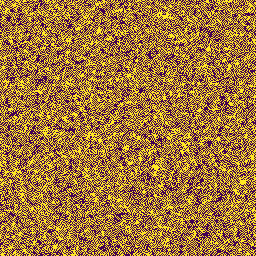

In [11]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import IPython.display

# --- Simulation Parameters ---
LATTICE_SIZE = 256
TEMPERATURE = 2.269  # Critical temperature for 2D Ising is ~2.269 (J=1, k_B=1)
# Try other temperatures: T_low = 1.0 (ordered), T_high = 5.0 (disordered)
BETA = 1.0 / TEMPERATURE
TOTAL_MCS = 500
PLOT_EVERY = 25

# Get viridis colormap
viridis = plt.cm.viridis
norm = Normalize(vmin=-1, vmax=1)

lattice_0 = wp.empty((LATTICE_SIZE, LATTICE_SIZE), dtype=wp.int8)
lattice_1 = wp.empty((LATTICE_SIZE, LATTICE_SIZE), dtype=wp.int8)

# Reset initial conditions
wp.launch(generate_lattice, lattice_0.shape, inputs=[lattice_0, 42])

# Collect frames as arrays instead of images
frames = []

for i in range(200):
    wp.launch(update_lattice, lattice_0.shape, inputs=[BETA, i, lattice_0, lattice_1])
    lattice_0, lattice_1 = lattice_1, lattice_0

    # Copy to CPU and apply colormap
    normalized_lattice = norm(lattice_0.numpy())
    colored_frame = viridis(normalized_lattice)

    # Convert to RGB
    rgb_frame = (colored_frame[:, :, :3] * 255).astype(np.uint8)
    frames.append(rgb_frame)

# Convert to PIL images and save
pil_images = [Image.fromarray(frame, mode="RGB") for frame in frames]
output_filename = f"output/{LATTICE_SIZE}x{LATTICE_SIZE}_{TEMPERATURE}.gif"

pil_images[0].save(
    output_filename, save_all=True, append_images=pil_images[1:], duration=100, loop=0
)

IPython.display.Image(output_filename)

This is still not looking right. Why?